## Imports

In [ ]:
import torch
import torchvision


## Download MNIST

In [3]:
# generate the MNIST dataset
transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])
mnist_dset = torchvision.datasets.MNIST("mnist", download=True, transform=transforms)
print(mnist_dset[0][0].shape)

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1000)>



100%|██████████| 9.91M/9.91M [00:18<00:00, 523kB/s]


Extracting mnist\MNIST\raw\train-images-idx3-ubyte.gz to mnist\MNIST\raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1000)>



100%|██████████| 28.9k/28.9k [00:00<00:00, 228kB/s]


Extracting mnist\MNIST\raw\train-labels-idx1-ubyte.gz to mnist\MNIST\raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1000)>



100%|██████████| 1.65M/1.65M [00:02<00:00, 575kB/s]


Extracting mnist\MNIST\raw\t10k-images-idx3-ubyte.gz to mnist\MNIST\raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1000)>



100%|██████████| 4.54k/4.54k [00:00<?, ?B/s]


Extracting mnist\MNIST\raw\t10k-labels-idx1-ubyte.gz to mnist\MNIST\raw

torch.Size([1, 28, 28])


## Sample from MNIST

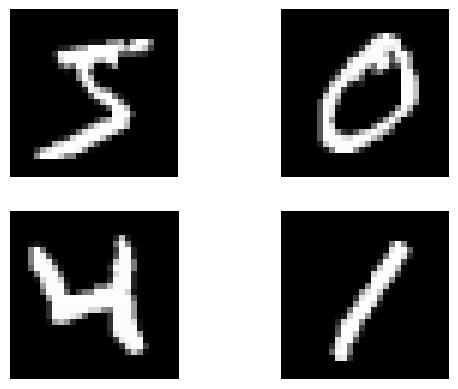

In [21]:
# show a sample
import matplotlib.pyplot as plt
# the first index is for the dataset, the second is for the tuple, the third one is for channel


f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(mnist_dset[0][0][0], cmap='gray')
axarr[0,1].imshow(mnist_dset[1][0][0], cmap='gray')
axarr[1,0].imshow(mnist_dset[20][0][0], cmap='gray')
axarr[1,1].imshow(mnist_dset[23][0][0], cmap='gray')
axarr[0,0].axis('off')
axarr[0,1].axis('off')
axarr[1,0].axis('off')
axarr[1,1].axis('off')


plt.show()

## UNET 

In [ ]:
class ScoreNetwork0(torch.nn.Module):
    # takes an input image and time, returns the score function
    def __init__(self):
        super().__init__()
        nch = 2
        chs = [32, 64, 128, 256, 256]
        self._convs = torch.nn.ModuleList([
            torch.nn.Sequential(
                torch.nn.Conv2d(2, chs[0], kernel_size=3, padding=1),  # (batch, ch, 28, 28)
                torch.nn.LogSigmoid(),  # (batch, 8, 28, 28)
            ),
            torch.nn.Sequential(
                torch.nn.MaxPool2d(kernel_size=2, stride=2),  # (batch, ch, 14, 14)
                torch.nn.Conv2d(chs[0], chs[1], kernel_size=3, padding=1),  # (batch, ch, 14, 14)
                torch.nn.LogSigmoid(),  # (batch, 16, 14, 14)
            ),
            torch.nn.Sequential(
                torch.nn.MaxPool2d(kernel_size=2, stride=2),  # (batch, ch, 7, 7)
                torch.nn.Conv2d(chs[1], chs[2], kernel_size=3, padding=1),  # (batch, ch, 7, 7)
                torch.nn.LogSigmoid(),  # (batch, 32, 7, 7)
            ),
            torch.nn.Sequential(
                torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=1),  # (batch, ch, 4, 4)
                torch.nn.Conv2d(chs[2], chs[3], kernel_size=3, padding=1),  # (batch, ch, 4, 4)
                torch.nn.LogSigmoid(),  # (batch, 64, 4, 4)
            ),
            torch.nn.Sequential(
                torch.nn.MaxPool2d(kernel_size=2, stride=2),  # (batch, ch, 2, 2)
                torch.nn.Conv2d(chs[3], chs[4], kernel_size=3, padding=1),  # (batch, ch, 2, 2)
                torch.nn.LogSigmoid(),  # (batch, 64, 2, 2)
            ),
        ])
        self._tconvs = torch.nn.ModuleList([
            torch.nn.Sequential(
                # input is the output of convs[4]
                torch.nn.ConvTranspose2d(chs[4], chs[3], kernel_size=3, stride=2, padding=1, output_padding=1),  # (batch, 64, 4, 4)
                torch.nn.LogSigmoid(),
            ),
            torch.nn.Sequential(
                # input is the output from the above sequential concated with the output from convs[3]
                torch.nn.ConvTranspose2d(chs[3] * 2, chs[2], kernel_size=3, stride=2, padding=1, output_padding=0),  # (batch, 32, 7, 7)
                torch.nn.LogSigmoid(),
            ),
            torch.nn.Sequential(
                # input is the output from the above sequential concated with the output from convs[2]
                torch.nn.ConvTranspose2d(chs[2] * 2, chs[1], kernel_size=3, stride=2, padding=1, output_padding=1),  # (batch, chs[2], 14, 14)
                torch.nn.LogSigmoid(),
            ),
            torch.nn.Sequential(
                # input is the output from the above sequential concated with the output from convs[1]
                torch.nn.ConvTranspose2d(chs[1] * 2, chs[0], kernel_size=3, stride=2, padding=1, output_padding=1),  # (batch, chs[1], 28, 28)
                torch.nn.LogSigmoid(),
            ),
            torch.nn.Sequential(
                # input is the output from the above sequential concated with the output from convs[0]
                torch.nn.Conv2d(chs[0] * 2, chs[0], kernel_size=3, padding=1),  # (batch, chs[0], 28, 28)
                torch.nn.LogSigmoid(),
                torch.nn.Conv2d(chs[0], 1, kernel_size=3, padding=1),  # (batch, 1, 28, 28)
            ),
        ])

    def forward(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        # x: (..., ch0 * 28 * 28), t: (..., 1)
        x2 = torch.reshape(x, (*x.shape[:-1], 1, 28, 28))  # (..., ch0, 28, 28)
        tt = t[..., None, None].expand(*t.shape[:-1], 1, 28, 28)  # (..., 1, 28, 28)
        x2t = torch.cat((x2, tt), dim=-3)
        signal = x2t
        signals = []
        for i, conv in enumerate(self._convs):
            signal = conv(signal)
            if i < len(self._convs) - 1:
                signals.append(signal)

        for i, tconv in enumerate(self._tconvs):
            if i == 0:
                signal = tconv(signal)
            else:
                signal = torch.cat((signal, signals[-i]), dim=-3)
                signal = tconv(signal)
        signal = torch.reshape(signal, (*signal.shape[:-3], -1))  # (..., 1 * 28 * 28)
        return signal

score_network = ScoreNetwork0()

## Loss scoring

In [ ]:
def calc_loss(score_network: torch.nn.Module, x: torch.Tensor) -> torch.Tensor:
    # x: (batch_size, nch) is the training data
    
    # sample the time
    t = torch.rand((x.shape[0], 1), dtype=x.dtype, device=x.device) * (1 - 1e-4) + 1e-4

    # calculate the terms for the posterior log distribution
    int_beta = (0.1 + 0.5 * (20 - 0.1) * t) * t  # integral of beta
    mu_t = x * torch.exp(-0.5 * int_beta)
    var_t = -torch.expm1(-int_beta)
    x_t = torch.randn_like(x) * var_t ** 0.5 + mu_t
    grad_log_p = -(x_t - mu_t) / var_t  # (batch_size, nch)

    # calculate the score function
    score = score_network(x_t, t)  # score: (batch_size, nch)

    # calculate the loss function
    loss = (score - grad_log_p) ** 2
    lmbda_t = var_t
    weighted_loss = lmbda_t * loss
    return torch.mean(weighted_loss)

## Training loop

In [ ]:
# start the training loop
import time
opt = torch.optim.Adam(score_network.parameters(), lr=3e-4)
dloader = torch.utils.data.DataLoader(mnist_dset, batch_size=64, shuffle=True)
device = torch.device('cuda:0')  # change this if you don't have a gpu
score_network = score_network.to(device)
t0 = time.time()
for i_epoch in range(400):
    total_loss = 0
    for data, _ in dloader:  # we don't need the data class
        data = data.reshape(data.shape[0], -1).to(device)
        opt.zero_grad()

        # training step
        loss = calc_loss(score_network, data)
        loss.backward()
        opt.step()

        # running stats
        total_loss = total_loss + loss.detach().item() * data.shape[0]

    # print the training stats
    if i_epoch % 20 == 0:
        print(f"{i_epoch} ({time.time() - t0}s): {total_loss / len(mnist_dset)}")